Task is to predict stock prices for a few days, which is a time series problem

In [5]:
import numpy as np 
import pandas as pd
from nsepy import get_history as gh
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

fetching historical data from 2015 till now.

In [9]:
start = dt.datetime(2015,1,1)
end = dt.datetime.today()
data = gh(symbol='SBIN',start=start,end=end)
data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,SBIN,EQ,311.85,312.45,315.00,310.70,314.0,314.00,313.67,6138488,1.925489e+14,58688,1877677,0.3059
2015-01-02,SBIN,EQ,314.00,314.35,318.30,314.35,315.6,315.25,316.80,9935094,3.147389e+14,79553,4221685,0.4249
2015-01-05,SBIN,EQ,315.25,316.25,316.80,312.10,312.8,312.75,313.84,9136716,2.867432e+14,88236,3845173,0.4208
2015-01-06,SBIN,EQ,312.75,310.00,311.10,298.70,299.9,299.90,305.14,15329257,4.677601e+14,169268,7424847,0.4844
2015-01-07,SBIN,EQ,299.90,300.00,302.55,295.15,301.4,300.15,299.95,15046745,4.513243e+14,147185,5631400,0.3743


Visualizing data 

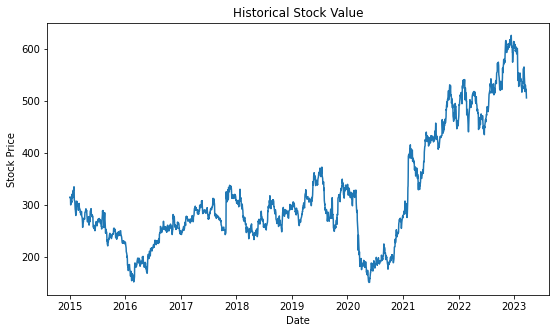

In [14]:
plt.figure(figsize=(9,5))
plt.plot(data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

trimming all other colums besides Date, Close Open, High Low CLose

In [15]:
data['Date'] = data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = data['Date']
data2['Open'] = data['Open']
data2['High'] = data['High']
data2['Low'] = data['Low']
data2['Close'] = data['Close']

preprocessing training data

In [21]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_scaled = sc.fit_transform(train_set)

X_train = []
Y_train = []

for i in range(60, 1482):
  X_train.append(training_scaled[i-60:i, 0])
  Y_train.append(training_scaled[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Defining LSTM Network

In [22]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

compiling the model

In [25]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
45/45 [==============================] - 15s 127ms/step - loss: 0.0013
Epoch 2/20
45/45 [==============================] - 7s 154ms/step - loss: 9.7850e-04
Epoch 3/20
45/45 [==============================] - 6s 128ms/step - loss: 0.0010
Epoch 4/20
45/45 [==============================] - 7s 153ms/step - loss: 9.6602e-04
Epoch 5/20
45/45 [==============================] - 6s 128ms/step - loss: 8.5083e-04
Epoch 6/20
45/45 [==============================] - 7s 154ms/step - loss: 9.3011e-04
Epoch 7/20
45/45 [==============================] - 6s 128ms/step - loss: 8.3815e-04
Epoch 8/20
45/45 [==============================] - 7s 156ms/step - loss: 8.1992e-04
Epoch 9/20
45/45 [==============================] - 6s 127ms/step - loss: 7.5445e-04
Epoch 10/20
45/45 [==============================] - 7s 155ms/step - loss: 6.7696e-04
Epoch 11/20
45/45 [==============================] - 6s 128ms/step - loss: 7.1138e-04
Epoch 12/20
45/45 [==============================] - 7s 155ms/step - l

testing will be done on newly fetched data

In [56]:
testdataframe= gh(symbol='SBIN',start=dt.datetime(2022,7,1),end=dt.datetime.today())
testdataframe['Date'] = testdataframe.index

testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']

real_stock_price = testdata.iloc[:, 1:2].values

dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)

inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 235):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Testing Model on new Data 

In [57]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

6/6 [==============================] - 0s 34ms/step


plotting

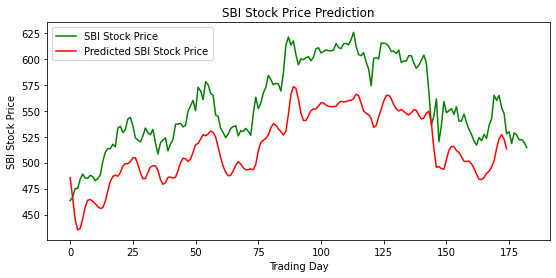

In [58]:
plt.figure(figsize=(9,4))
plt.plot(real_stock_price, color = 'green', label = 'SBI Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()